# Chapter 3: Truss Optimization

Introduction to quantum annealing using D-Wave systems and QUBO formulations.

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions


In [1]:
# Setup and imports for D-Wave
import numpy as np
import matplotlib.pyplot as plt

from Chapter03_TrussOptimization_functions import (
    TrussFEM, search_design_space, simulated_annealing)

print('Setup complete!')

Setup complete!


## 3 x 3 truss example

In [2]:
# Example usage with the 3x3 truss
nodes = np.array([
    [0.0, 0.0],   # Node 0 (bottom left) - FIXED
    [2.0, 0.0],   # Node 1 (bottom center)
    [4.0, 0.0],   # Node 2 (bottom right) - FIXED
    [0.0, 1.5],   # Node 3 (middle left)
    [2.0, 1.5],   # Node 4 (middle center)
    [4.0, 1.5],   # Node 5 (middle right)
    [0.0, 3.0],   # Node 6 (top left)
    [2.0, 3.0],   # Node 7 (top center) - LOADED
    [4.0, 3.0]    # Node 8 (top right)
])

elements = [
    (0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8),  # Horizontal
    (0, 3), (3, 6), (1, 4), (4, 7), (2, 5), (5, 8),  # Vertical
    (0, 4), (1, 3), (1, 5), (2, 4), (3, 7), (4, 6), (4, 8), (5, 7),  # Diagonals
    (0, 8), (2, 6), (0, 7), (1, 6), (1, 8), (2, 7)   # Long diagonals
]

# Create FEM model
fem_model = TrussFEM(nodes, elements, E=200e9, A=0.001, rho=7850)

# Define problem
fixed_dofs = [0, 1, 4, 5]  # Nodes 0 and 2 fixed
loads = np.zeros(2 * len(nodes))
loads[2*7 + 1] = -10000  # 10 kN downward at node 7


# Design constraints
u_max = 0.01      # Maximum displacement: 0.01 m = 10 mm
sigma_max = 250e6 # Yield stress: 250 MPa

# Test with a sample design (all members active)
design_full = np.ones(len(elements), dtype=int)

u, valid = fem_model.solve(design_full, loads, fixed_dofs)


print(f"\nEvaluating full ground structure (all {len(elements)} members active)...")
metrics = fem_model.evaluate_design(design_full, loads, fixed_dofs, 
                                    u_max=u_max, sigma_max=sigma_max)

print(f"\nResults for full ground structure:")
print(f"  Weight: {metrics['weight']:.2f} kg")
print(f"  Max displacement: {metrics['max_disp']*1000:.4f} mm")
print(f"  Max stress: {metrics['max_stress']/1e6:.2f} MPa")
print(f"  Compliance: {metrics['compliance']:.2f} J")
print(f"  Feasible: {metrics['feasible']}")




Evaluating full ground structure (all 26 members active)...

Results for full ground structure:
  Weight: 513.56 kg
  Max displacement: 0.0568 mm
  Max stress: 3.64 MPa
  Compliance: 0.57 J
  Feasible: True


Plotting ground structure...


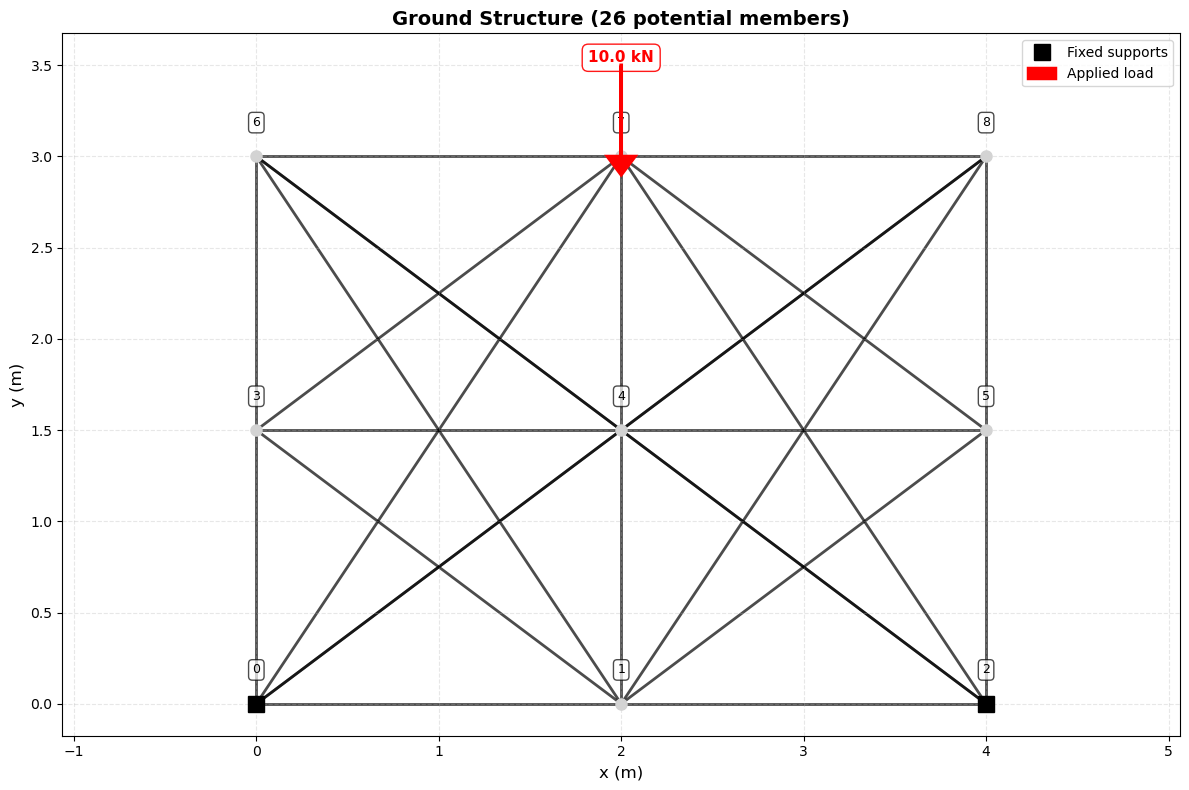

In [3]:
# Example 1: Plot ground structure
print("Plotting ground structure...")
fem_model.plot_truss(loads=loads, fixed_dofs=fixed_dofs, 
                    show_labels=True,
                    title="Ground Structure (26 potential members)")



Plotting structure with displacements...


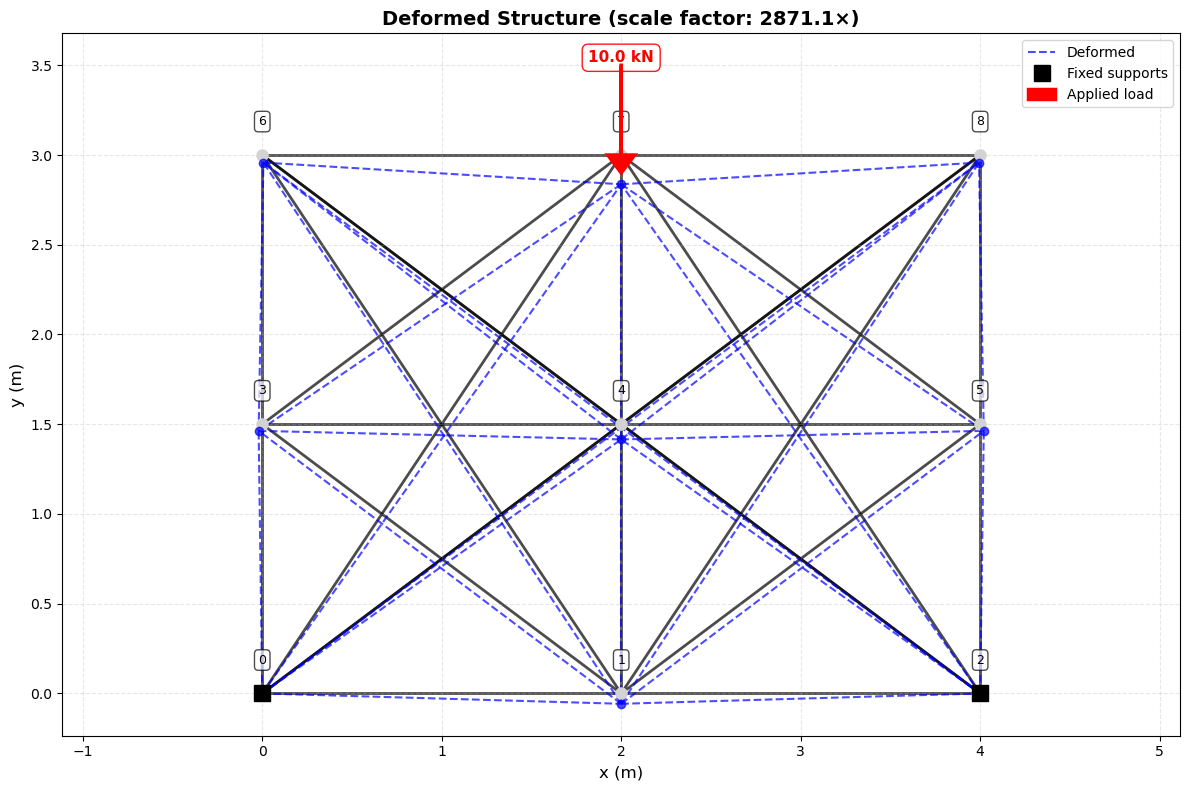

In [4]:
print("\nPlotting structure with displacements...")
scale_factor = 0.02/u.max()
fem_model.plot_truss(design=design_full, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f}×)")

In [5]:

# Example 2: Plot with a specific design

design_candidate = np.array([
    # Horizontal members (indices 0-5)
    1, 1,  # Bottom row: (0,1), (1,2) - CRITICAL for node 1 stability
    1, 1,  # Middle row: (3,4), (4,5) - lateral bracing
    0, 0,  # Top row: not needed (nodes 6,8 hanging)
    
    # Vertical members (indices 6-11)
    1, 0,  # Left column: (0,3) active
    1, 1,  # Center column: (1,4), (4,7) - load path
    1, 0,  # Right column: (2,5) active
    
    # In-square diagonals (indices 12-19)
    1, 0,  # (0,4) diagonal bracing
    0, 1,  # (2,4) diagonal bracing
    1, 0,  # (3,7) diagonal bracing
    0, 1,  # (5,7) diagonal bracing
    
    # Long diagonals (indices 20-25)
    0, 0, 0, 0, 0, 0
], dtype=int)

u_opt, valid_opt = fem_model.solve(design_candidate, loads, fixed_dofs)
print(f"Number of active members: {np.sum(design_candidate)}")  # 10 members

metrics = fem_model.evaluate_design(design_candidate, loads, fixed_dofs, 
                                    u_max=u_max, sigma_max=sigma_max)

print(f"\nResults for candidate structure:")
print(f"  Weight: {metrics['weight']:.2f} kg")
print(f"  Max displacement: {metrics['max_disp']*1000:.4f} mm")
print(f"  Max stress: {metrics['max_stress']/1e6:.2f} MPa")
print(f"  Compliance: {metrics['compliance']:.2f} J")
print(f"  Feasible: {metrics['feasible']}")




Number of active members: 12

Results for candidate structure:
  Weight: 188.40 kg
  Max displacement: 0.1359 mm
  Max stress: 5.47 MPa
  Compliance: 1.36 J
  Feasible: True


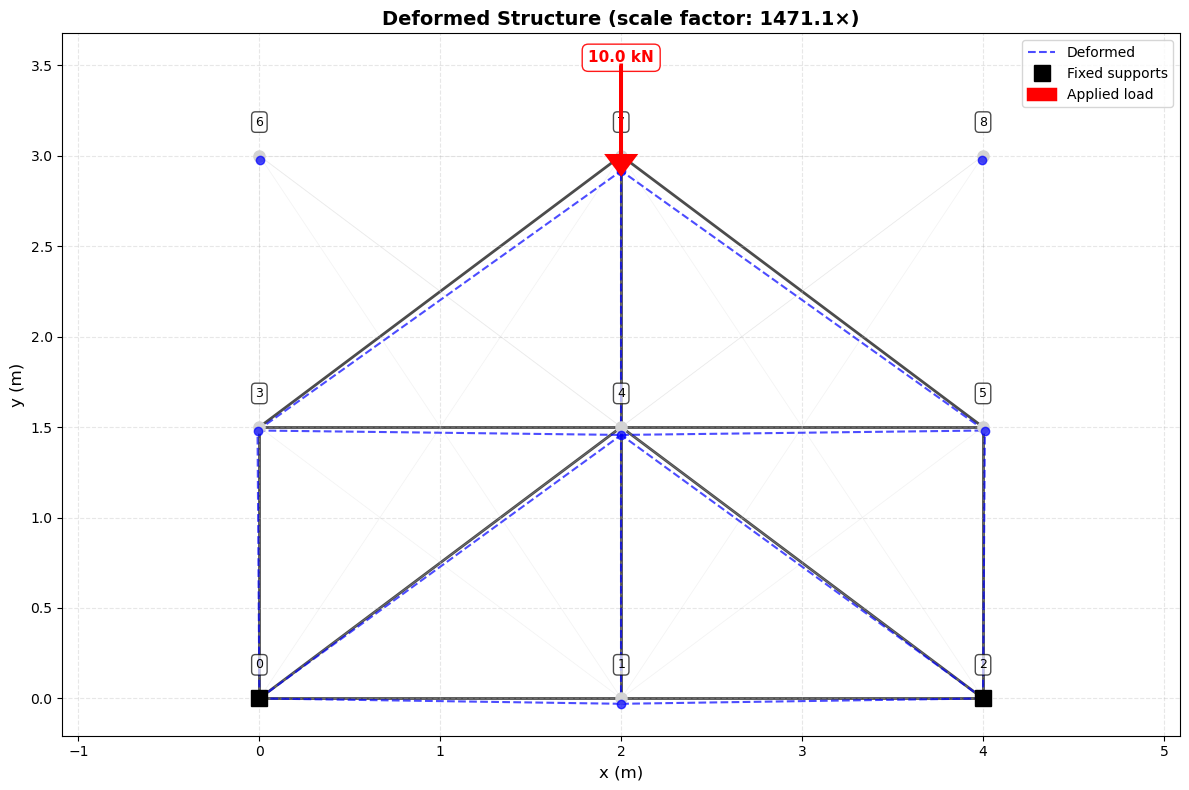

In [6]:
scale_factor =0.2/abs(u_opt).max()
fem_model.plot_truss(design=design_candidate, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f}×)")


## Pareto space

In [7]:
N = len(elements) # all elements
M = 10000  # number of random samples
best_design = search_design_space(fem_model, loads, fixed_dofs, N, M)



Sampling 10,000 random designs from 2^26 = 67,108,864 possible designs
Sampling rate: 0.0149%



Progress:  10.0% (1,000/10,000) | Elapsed: 0.2s | Remaining: ~1.5s | Feasible: 3
Progress:  20.0% (2,000/10,000) | Elapsed: 0.3s | Remaining: ~1.2s | Feasible: 9
Progress:  30.0% (3,000/10,000) | Elapsed: 0.4s | Remaining: ~1.0s | Feasible: 14
Progress:  40.0% (4,000/10,000) | Elapsed: 0.6s | Remaining: ~0.9s | Feasible: 153
Progress:  50.0% (5,000/10,000) | Elapsed: 0.9s | Remaining: ~0.9s | Feasible: 346
Progress:  60.0% (6,000/10,000) | Elapsed: 1.1s | Remaining: ~0.8s | Feasible: 533
Progress:  70.0% (7,000/10,000) | Elapsed: 1.5s | Remaining: ~0.6s | Feasible: 925
Progress:  80.0% (8,000/10,000) | Elapsed: 2.0s | Remaining: ~0.5s | Feasible: 1711
Progress:  90.0% (9,000/10,000) | Elapsed: 2.5s | Remaining: ~0.3s | Feasible: 2475
Progress: 100.0% (10,000/10,000) | Elapsed: 3.0s | Remaining: ~0.0s | Feasible: 3276

Completed in 2.99 seconds (0.30 ms per design)
Found 3276 feasible designs out of 10,000 sampled
Feasibility rate: 32.76%

Design Space Statistics:
Best design:
  Weight:

C:\Users\ksure\AppData\Local\Temp\ipykernel_17220\2490331517.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  scale_factor = 0.2/abs(u_opt).max()
d:\Dropbox\Personal\suresh\Software\Github\ERSL-Private\QCTextSoftware\Chapter03_TrussOptimization_functions.py:320: RuntimeWarning: invalid value encountered in scalar multiply
  deformed_nodes[i, 0] += scale_factor * displacements[2*i]
d:\Dropbox\Personal\suresh\Software\Github\ERSL-Private\QCTextSoftware\Chapter03_TrussOptimization_functions.py:321: RuntimeWarning: invalid value encountered in scalar multiply
  deformed_nodes[i, 1] += scale_factor * displacements[2*i+1]


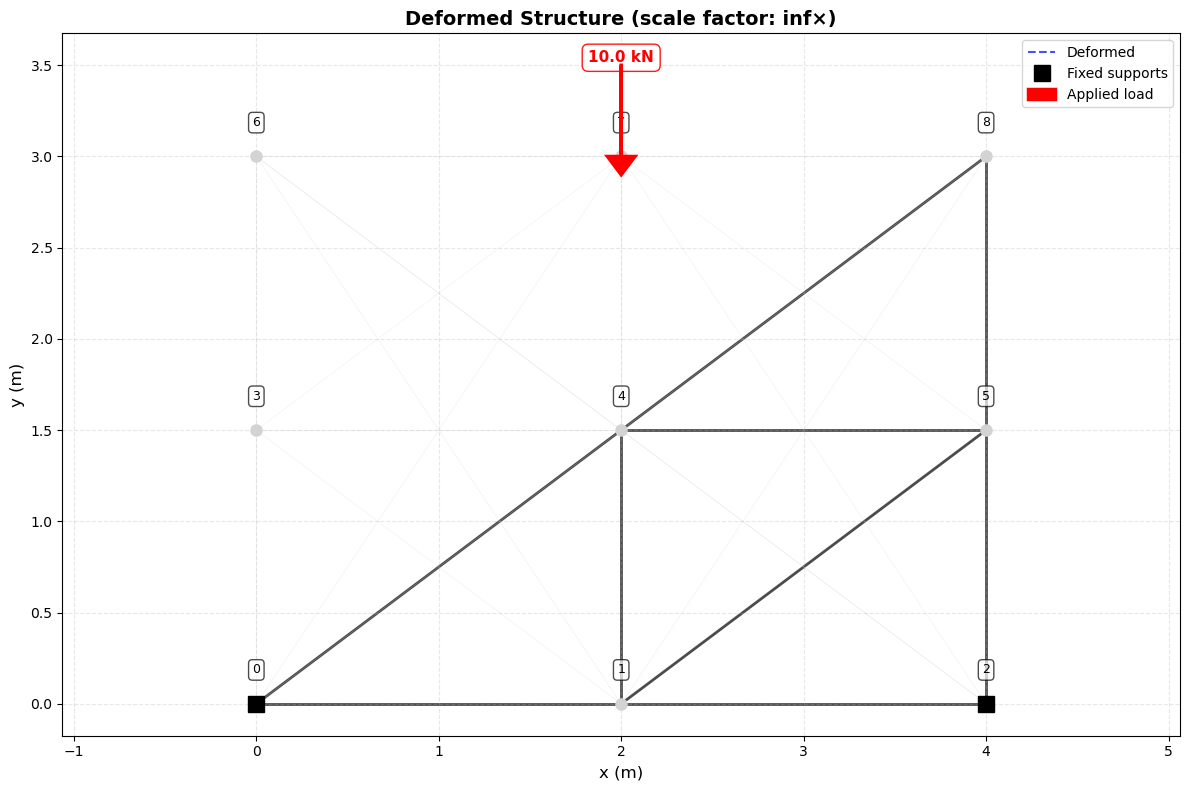

In [8]:
u_opt, valid_opt = fem_model.solve(best_design, loads, fixed_dofs)

metrics = fem_model.evaluate_design(best_design, loads, fixed_dofs, 
                                    u_max=u_max, sigma_max=sigma_max)

scale_factor = 0.2/abs(u_opt).max()
fem_model.plot_truss(design=best_design, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u_opt, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f}×)")



## Simulated Annealing

Starting SA: T_init=1000, T_min=0.1, alpha=0.99
Iteration 1000: T=904.38, Best fitness=248.93
Iteration 2000: T=817.91, Best fitness=244.18
Iteration 3000: T=739.70, Best fitness=244.18
Iteration 4000: T=668.97, Best fitness=235.50
Iteration 5000: T=605.01, Best fitness=235.50
Iteration 6000: T=547.16, Best fitness=235.50
Iteration 7000: T=494.84, Best fitness=235.50
Iteration 8000: T=447.52, Best fitness=235.50
Iteration 9000: T=404.73, Best fitness=235.50
Iteration 10000: T=366.03, Best fitness=235.50
Iteration 11000: T=331.03, Best fitness=235.50
Iteration 12000: T=299.38, Best fitness=235.50
Iteration 13000: T=270.75, Best fitness=235.50
Iteration 14000: T=244.87, Best fitness=235.50
Iteration 15000: T=221.45, Best fitness=235.50
Iteration 16000: T=200.28, Best fitness=235.50
Iteration 17000: T=181.13, Best fitness=235.50
Iteration 18000: T=163.81, Best fitness=235.50
Iteration 19000: T=148.14, Best fitness=235.50
Iteration 20000: T=133.98, Best fitness=235.50
Iteration 21000: T=12

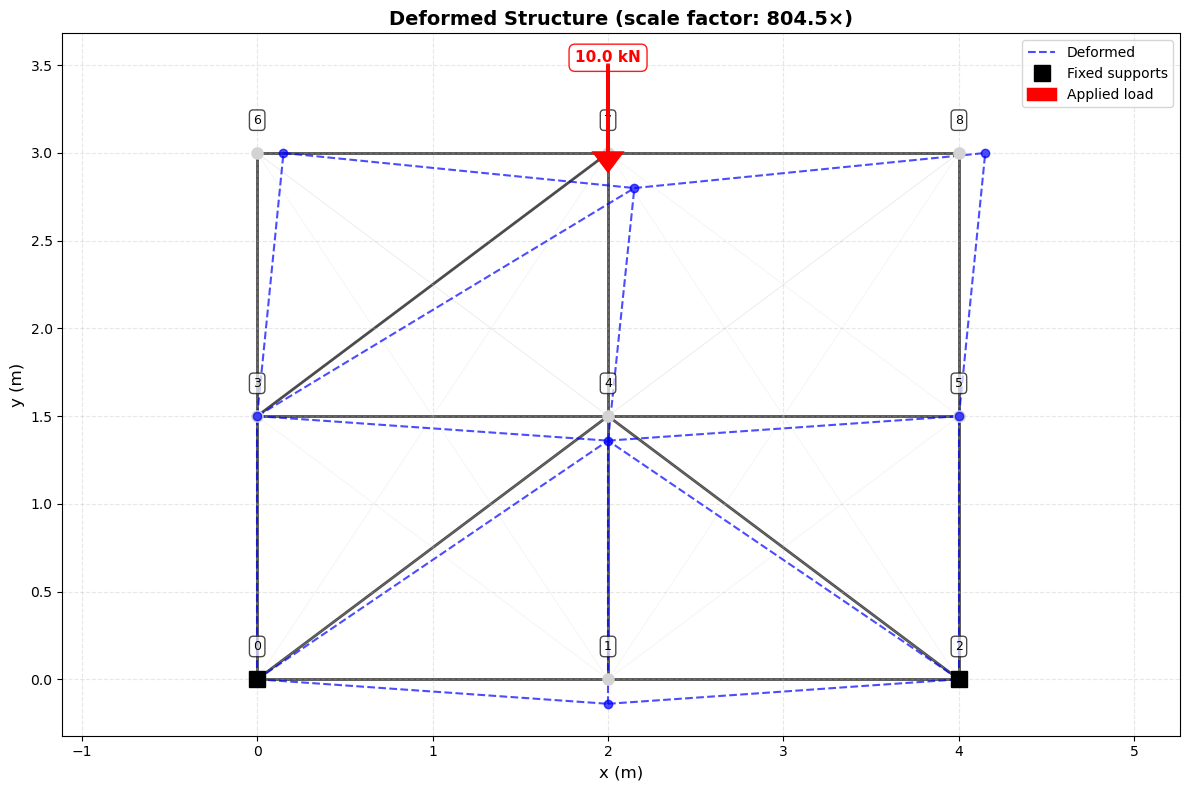

In [10]:
best_SA_design = simulated_annealing(fem_model, loads, fixed_dofs, N,
                       T_init=1000, T_min=0.1, alpha=0.99, 
                       steps_per_temp=100)

u_opt, valid_opt = fem_model.solve(best_SA_design, loads, fixed_dofs)

metrics = fem_model.evaluate_design(best_SA_design, loads, fixed_dofs, 
                                    u_max=u_max, sigma_max=sigma_max)

scale_factor = 0.2/abs(u_opt).max()
fem_model.plot_truss(design=best_SA_design, loads=loads, fixed_dofs=fixed_dofs,
                    displacements=u_opt, scale_factor=scale_factor,
                    show_labels=True,
                    title=f"Deformed Structure (scale factor: {scale_factor:.1f}×)")
